## 3.2. Linear Regression Implementation from Scratch

Now that you understand the key ideas behind linear regression, we can begin to work through a hands-on implementation in code. In this section, we will implement the entire method from scratch, including the data pipeline, the model, the loss function, and the minibatch stochastic gradient descent optimiser. While modern deep learning frameworks can automate nearly all of this work, implementing things from scratch is the only way to make sure that you really know what you're doing. Moreover, when it comes time to customise models, defining our own layers or loss functions, understanding how things work under the hood will prove handy. In this section, we will rely only on tensors and auto differentation. Afterwards, we will introduct a more concise implementation, taking advantage of the bells and whistles of deep learning frameworks.

In [5]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1. Generating the Dataset

To keep things simple, we will construct an artificial dataset according to a linear model with additive noise. Our task will be to recover this model's parameters using the finite set of examples contained in our dataset. We will keep the data low-dimensional so we can visualise it easily. In the following code snippet, we generate a dataset containing 1000 examples, each consisting of 2 features sampled from a standard normal distribution. Thuse our synthetic dataset will be a matrix $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**

You could think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with mean of 0.
To make our problem easy, we will set its standard deviation to 0.01.
The following code generates our synthetic dataset.

In [6]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that each row in features consists of a 2-dimensional data example 
and that each row in labels consists of a 1-dimensional label value 
(a scalar).

In [7]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.1884, -0.4260]) 
label: tensor([5.2619])


By generating a scatter plot using the second feature features[:, 1] and labels, we can clearly observe the linear correlation between the two.

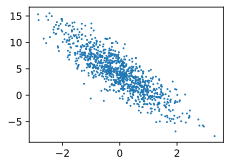

In [8]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2. Reading the Dataset

Recall that training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. Since this process is so fundamental to training machine learning algorithms, it is worth defining a utility function to shuffle the dataset and access it in minibatches.

In the following code, we define the `data_iter` function to demonstrate one possible implementation of this functionality. the function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size `batch_size`. Each minibatch consists of a tuple of features and labels.

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In general, note that we want to use reasonably sized minibatches to take advantage of the GPU hardware, which excels at parallelizing operations. Because each example can be fed through our models in parallel and the gradient of the loss function for each example can also be taken in parallel, GPUs allow us to process hundreds of examples in scarcely more time than it might take to process just a single example.

To build some intuition, let us read and print the first small batch of data examples. The shape of the features in each minibatch tells us both the minibatch size and the number of input features. Likewise, 
our minibatch of labels will have a shape given by `batch_size`.

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.2737,  0.6349],
        [-0.0414,  0.7643],
        [-0.5589,  0.8804],
        [ 1.2559,  1.7579],
        [-0.9386, -0.8232],
        [-0.1501, -0.7405],
        [ 1.5237,  0.8129],
        [ 1.0895, -2.1934],
        [ 0.0174, -1.4807],
        [-0.6280,  0.0997]]) 
 tensor([[ 1.4849],
        [ 1.5236],
        [ 0.0805],
        [ 0.7373],
        [ 5.1271],
        [ 6.4258],
        [ 4.4872],
        [13.8292],
        [ 9.2764],
        [ 2.6093]])


As we run the iteration, we obtain distinct minibatches successively until the entire dataset has been exhausted (try this). While the iteration implemented above is good for didactic purposes, it is inefficient in ways that might get us in trouble on real problems. For example, it requires that we load all the data in memory and that we perform lots of random memory access. The built-in iterators implemented in a deep learning framework are considerably more efficient and they can deal with both data stored in files and data 
fed via data streams.

### 3.2.3. Initialising Model Parameters

Before we can begin optimising our model's parameters by minibatch stochastic gradient descent, we need to have some parameters in the first place. In the following code, we initialise weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and set the bias to 0.

In [11]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

After initialising our parameters, our next task is to update them until they fit our data sufficiently well. Each update requires taking the gradient of our loss function with respect to the parameters. Given this gradient, we can update each parameter in the direction that may reduce the loss.

Since no one wants to compute gradients explicitly (it is tedious and error-prone), we use automatic differentiation, as introduced in Section 2.5, to compute the gradient.

### 3.2.4. Defining the Model

Next, we must define our model, relating its inputs and parameters to its outputs. Recall that to calculate the output of the linear model, we simply take the matrix-vector dot product of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
Note that below $\mathbf{Xw}$  is a vector and $b$ is a scalar.
Recall the broadcasting mechanism as described in Section 2.1.3. When we add a vector and a scalar, the scalar is added to each component of the vector.

In [12]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

### 3.2.5. Defining the Loss Function

Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first. Here, we will use the squared loss function as described in Section 3.1. In the implementation, we need to transform the true value `y` into the predicted value's shape `y_hat`. The result returned by the following function will also have the same shape as `y_hat`.

In [13]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6. Defining the Optimisation Algorithm

At each step, using one minibatch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters in the direction that may reduce the loss. The following code applies the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch 
size. The size of the update step is determined by the learning rate `lr`. Because our loss is calculated as a sum over the minibatch of examples, we normalize our step size by the batch size (`batch_size`), so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

In [14]:
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7. Training

Now that we have all of the parts in place, we are ready to implement the main training loop. 

In each iteration, we grab a minibatch of training examples, and pass them through our model to obtain a set of predictions. After calculating the loss, we initiate the backwards pass through the network, storing the gradients with respect to each parameter. Finally, we will call the optimisation algorithm `sgd` to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
(assuming that the number of examples is divisible by the batch size).
The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters,
which we set here to 3 and 0.03, respectively.
Unfortunately, setting hyperparameters is tricky
and requires some adjustment by trial and error.
We elide these details for now but revise them
later in Section 11.


In [15]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028996
epoch 2, loss 0.000098
epoch 3, loss 0.000050


In the above case, because we synthesized the dataset ourselves, we know precisely what the true parameters are. Thus, we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

In [16]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-0.0008, -0.0010], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0007], grad_fn=<RsubBackward1>)


Note that we should not take it for granted that we are able to recover the parameters perfectly. However, in machine learning, we are typically less concerned with recovering true underlying parameters, and more concerned with parameters that lead to highly accurate prediction. Fortunately, even on difficult optimization problems, stochastic gradient descent can often find remarkably good solutions, owing partly to the fact that, for deep networks, there exist many configurations of the parameters that lead to highly accurate prediction.

### 3.2.8. Summary

* We saw how a deep network can be implemented and optimised from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimisers.
* In the following sections, we will describe additional models based on the concepts that we have just explored and learn how to implement them more concisely.